# auto_annot_Smillie2019_with_Haber2017_dblabel

In [1]:
import besca as bc
import pandas as pd
import pkg_resources

.local/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


### Specify folders where .h5ad files are found and their names. 

The datasets that are already annotated and should be used for training. If you only use one dataset please use list of one.

In [2]:
adata_trains = [bc.datasets.Haber2017_processed()]

The dataset of interest that should be annotated.

In [3]:
adata_pred = bc.datasets.Smillie2019_processed()
adata_orig = bc.datasets.Smillie2019_processed()

Give your analysis a name.

In [4]:
analysis_name = 'auto_annot_Smillie2019_with_Haber2017_dblabel' 

### Now specify parameters

Specify column name of celltype annotation you want to train on.

In [5]:
celltype_train ='dblabel' 
celltype_test = 'dblabel'

Choose a method:

- linear: Support Vector Machine with Linear Kernel
- sgd: Support Vector Machine with Linear Kernel using Stochastic Gradient Descent
- rbf: Support Vector Machine with radial basis function kernel. Very time intensive, use only on small datasets.
- logistic_regression: Standard logistic classifier iwth multinomial loss.
- logistic_regression_ovr: Logistic Regression with one versus rest classification.
- logistic_regression_elastic: Logistic Regression with elastic loss, cross validates among multiple l1 ratios.

In [6]:
method = 'logistic_regression_elastic' # 'logistic_regression'

Specify merge method if using multiple training datasets. Needs to be either scanorama or naive.

In [7]:
merge = 'scanorama'

Decide if you want to use the raw format or highly variable genes. Raw increases computational time and does not necessarily improve predictions.

In [8]:
use_raw = False

You can choose to only consider a subset of genes from a signature set.

In [9]:
genes_to_use = 'all'

### Read in all training and the testing set.

In [10]:
# Select epithelial subset from Smillie2019 dataset
epithelial_subset = bc.subset_adata(adata_orig, adata_orig.obs.celltype_highlevel == 'Epi', raw=False)
adata_orig = epithelial_subset

In [11]:
# Convert mouse symbols (HGNC) to human symbols (MGI)
mousehuman_file = pkg_resources.resource_filename('besca', 'datasets/homologs/MGItoHGNC.csv')
mousehuman=pd.read_csv(mousehuman_file,sep='\t',header='infer', encoding="unicode_escape")
mousehuman.index=mousehuman['HGNC']
conversion=pd.Series(data=mousehuman['MGI'], index=mousehuman.index)

In [12]:
# Convert mouse symbols (HGNC) to human symbols (MGI)
adata_orig.var.rename(columns={'SYMBOL':'HGNC'}, inplace=True)
adata_orig.var['SYMBOL'] = adata_orig.var['HGNC'].map(lambda x: conversion.get(x, default='') if type(conversion.get(x, default='')) == str else str(conversion.get(x, default=None).values[0]))
adata_orig.var.index = adata_orig.var.SYMBOL
adata_orig.var_names_make_unique(join='abcdef')
adata_pred = adata_orig.copy()

This function merges training datasets, removes unwanted genes, and if scanorama is used corrects for datasets.

In [13]:
adata_train, adata_pred = bc.tl.auto_annot.merge_data(adata_trains, adata_pred, genes_to_use = genes_to_use, merge = merge)

merging with scanorama
using scanorama rn
Found 270 genes among all datasets
[[0.         0.77386197]
 [0.         0.        ]]
Processing datasets (0, 1)
integrating training set
calculating intersection


### Train the classifier.

The returned scaler is fitted on the training dataset (to zero mean and scaled to unit variance).

In [14]:
classifier, scaler = bc.tl.auto_annot.fit(adata_train, method, celltype_train)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


convergence after 15 epochs took 4 seconds
convergence after 15 epochs took 4 seconds
convergence after 16 epochs took 4 seconds
convergence after 35 epochs took 9 seconds
convergence after 38 epochs took 11 seconds
convergence after 42 epochs took 11 seconds
max_iter reached after 28 seconds
max_iter reached after 27 seconds
max_iter reached after 28 seconds
max_iter reached after 31 seconds
max_iter reached after 31 seconds
max_iter reached after 31 seconds
max_iter reached after 30 seconds
max_iter reached after 30 seconds
max_iter reached after 30 seconds
max_iter reached after 30 seconds
max_iter reached after 30 seconds
max_iter reached after 30 seconds
max_iter reached after 31 seconds
max_iter reached after 30 seconds
max_iter reached after 30 seconds
max_iter reached after 29 seconds
max_iter reached after 29 seconds
max_iter reached after 30 seconds
max_iter reached after 30 seconds
max_iter reached after 30 seconds
max_iter reached after 29 seconds
max_iter reached after 30 

[Parallel(n_jobs=10)]: Done   3 out of   3 | elapsed:  4.2min finished


### Prediction

Use fitted model to predict celltypes in adata_pred. Prediction will be added in a new column called 'auto_annot'. Paths are needed as adata_pred will revert to its original state (all genes, no additional corrections).
The threshold should be set to 0 or left out for SVM. For logisitic regression the threshold can be set.

In [15]:
adata_predicted = bc.tl.auto_annot.adata_predict(classifier = classifier, scaler = scaler, adata_pred = adata_pred, adata_orig = adata_orig, threshold = 0.5)

Write out metrics to a report file, create confusion matrices and comparative umap plots

In [16]:
adata_pred.obs

CELL                 Cluster        Health  \
0         N7.EpiA.AAGCAAGAGTCAAC-Epi              Cycling TA  Non-inflamed   
1         N7.EpiA.ACGAGGGAGCTGAT-Epi  Enterocyte Progenitors  Non-inflamed   
2         N7.EpiA.ACGTTTACTGGTAC-Epi  Immature Enterocytes 2  Non-inflamed   
3         N7.EpiA.AGAGAATGGTCATG-Epi  Enterocyte Progenitors  Non-inflamed   
4         N7.EpiA.AGAGCGGAGTATGC-Epi                    TA 1  Non-inflamed   
...                              ...                     ...           ...   
46097  N110.LPB.TTTCCTCCATTCTTAC-Epi                  Goblet      Inflamed   
46098  N110.LPB.TTTCCTCTCTGATTCT-Epi              Cycling TA      Inflamed   
46099  N110.LPB.TTTGCGCTCCAGAAGG-Epi              Cycling TA      Inflamed   
46100  N110.LPB.TTTGGTTGTGTGGCTC-Epi  Immature Enterocytes 2      Inflamed   
46101  N110.LPB.TTTGGTTTCCTTAATC-Epi                    TA 2      Inflamed   

      Location Subject celltype_highlevel  nGene   nUMI  \
0          Epi      N7                Epi   1507   7428   
1          Epi      N7                Epi    828   2877   
2          Epi      N7                Epi   2318  15332   
3          Epi      N7                Epi    884   3498   
4          Epi      N7                Epi    858   3261   
...        ...     ...                ...    ...    ...   
46097       LP    N110                Epi   1266   4944   
46098       LP    N110                Epi   3826  15878   
46099       LP    N110                Epi   3275  12559   
46100       LP    N110                Epi   2553  11705   
46101       LP    N110                Epi   3234  16164   

                   original_name  percent_mito  n_counts  n_genes batch  \
0         N7.EpiA.AAGCAAGAGTCAAC      0.057351    7428.0     1507    N7   
1         N7.EpiA.ACGAGGGAGCTGAT      0.009037    2877.0      828    N7   
2         N7.EpiA.ACGTTTACTGGTAC      0.133707   15332.0     2318    N7   
3         N7.EpiA.AGAGAATGGTCATG      0.002001    3498.0      884    N7   
4         N7.EpiA.AGAGCGGAGTATGC      0.003067    3261.0      858    N7   
...                          ...           ...       ...      ...   ...   
46097  N110.LPB.TTTCCTCCATTCTTAC      0.195793    4943.0     1266  N110   
46098  N110.LPB.TTTCCTCTCTGATTCT      0.100642   15877.0     3826  N110   
46099  N110.LPB.TTTGCGCTCCAGAAGG      0.079385   12559.0     3275  N110   
46100  N110.LPB.TTTGGTTGTGTGGCTC      0.130115   11705.0     2553  N110   
46101  N110.LPB.TTTGGTTTCCTTAATC      0.118721   16164.0     3234  N110   

      leiden                                dblabel         celltype  \
0          8  proliferating transit amplifying cell  epithelial cell   
1          0                  enterocyte progenitor  epithelial cell   
2          7                    immature enterocyte       enterocyte   
3          7                  enterocyte progenitor       enterocyte   
4          0                transit amplifying cell  epithelial cell   
...      ...                                    ...              ...   
46097      6                            goblet cell      goblet cell   
46098      8  proliferating transit amplifying cell  epithelial cell   
46099      8  proliferating transit amplifying cell  epithelial cell   
46100      7                    immature enterocyte       enterocyte   
46101      0                transit amplifying cell  epithelial cell   

         cluster_celltype        Type  
0      8: epithelial cell  Epithelial  
1      0: epithelial cell  Epithelial  
2           7: enterocyte  Epithelial  
3           7: enterocyte  Epithelial  
4      0: epithelial cell  Epithelial  
...                   ...         ...  
46097      6: goblet cell  Epithelial  
46098  8: epithelial cell  Epithelial  
46099  8: epithelial cell  Epithelial  
46100       7: enterocyte  Epithelial  
46101  0: epithelial cell  Epithelial  

[46102 rows x 18 columns]

... storing 'auto_annot' as categorical
... storing 'SYMBOL' as categorical


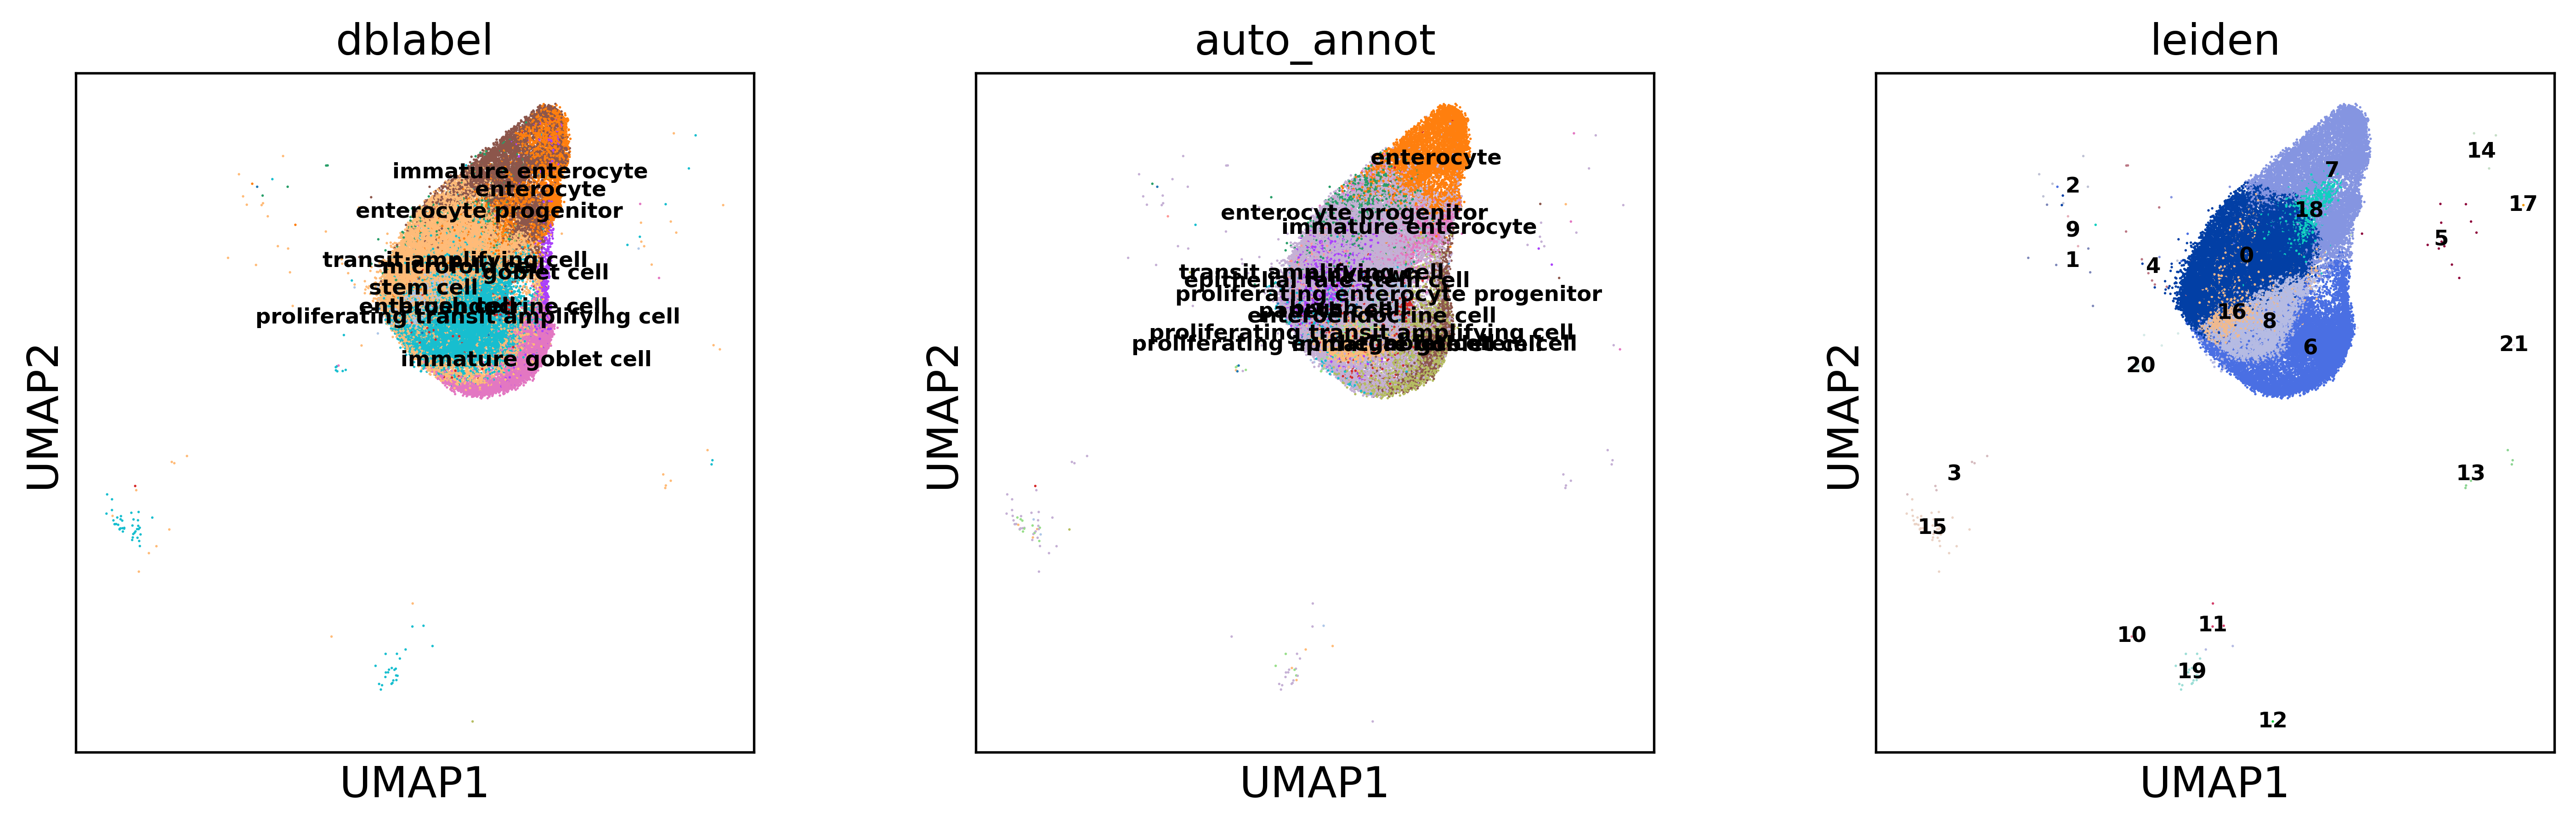

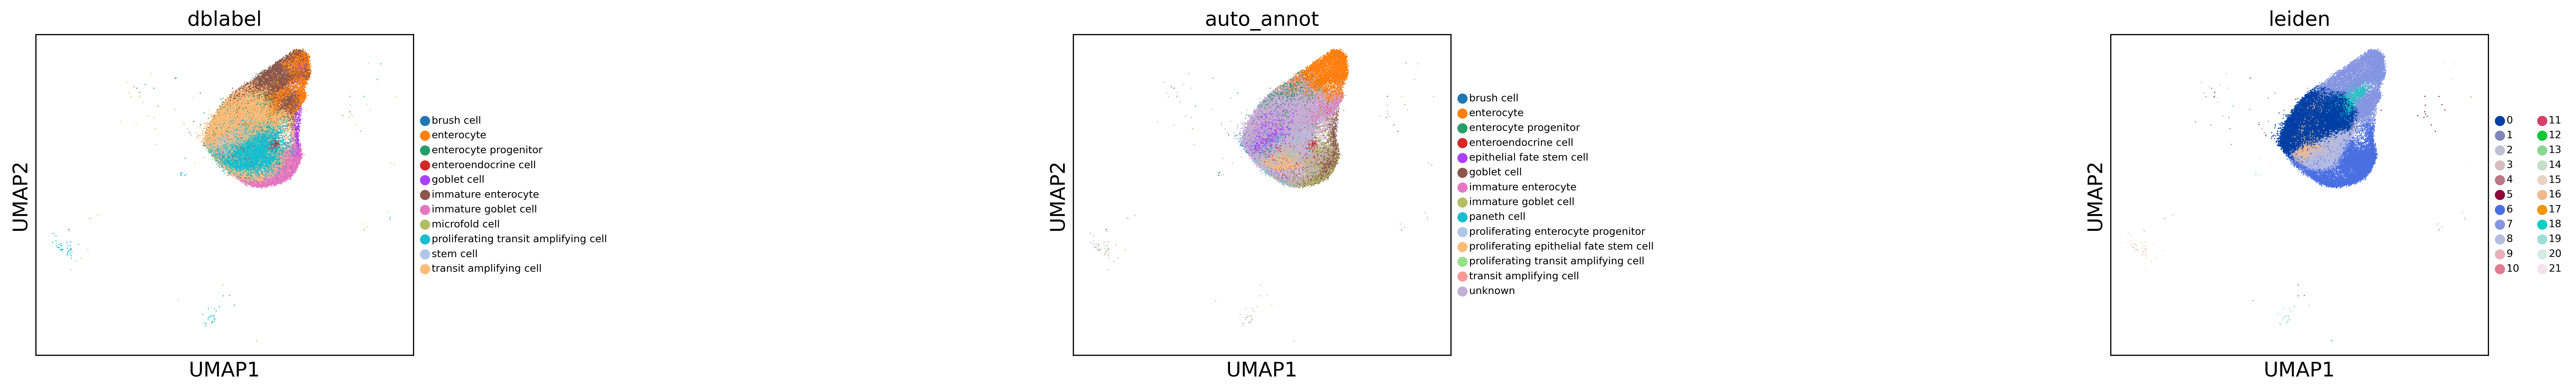

Confusion matrix, without normalization
Normalized confusion matrix


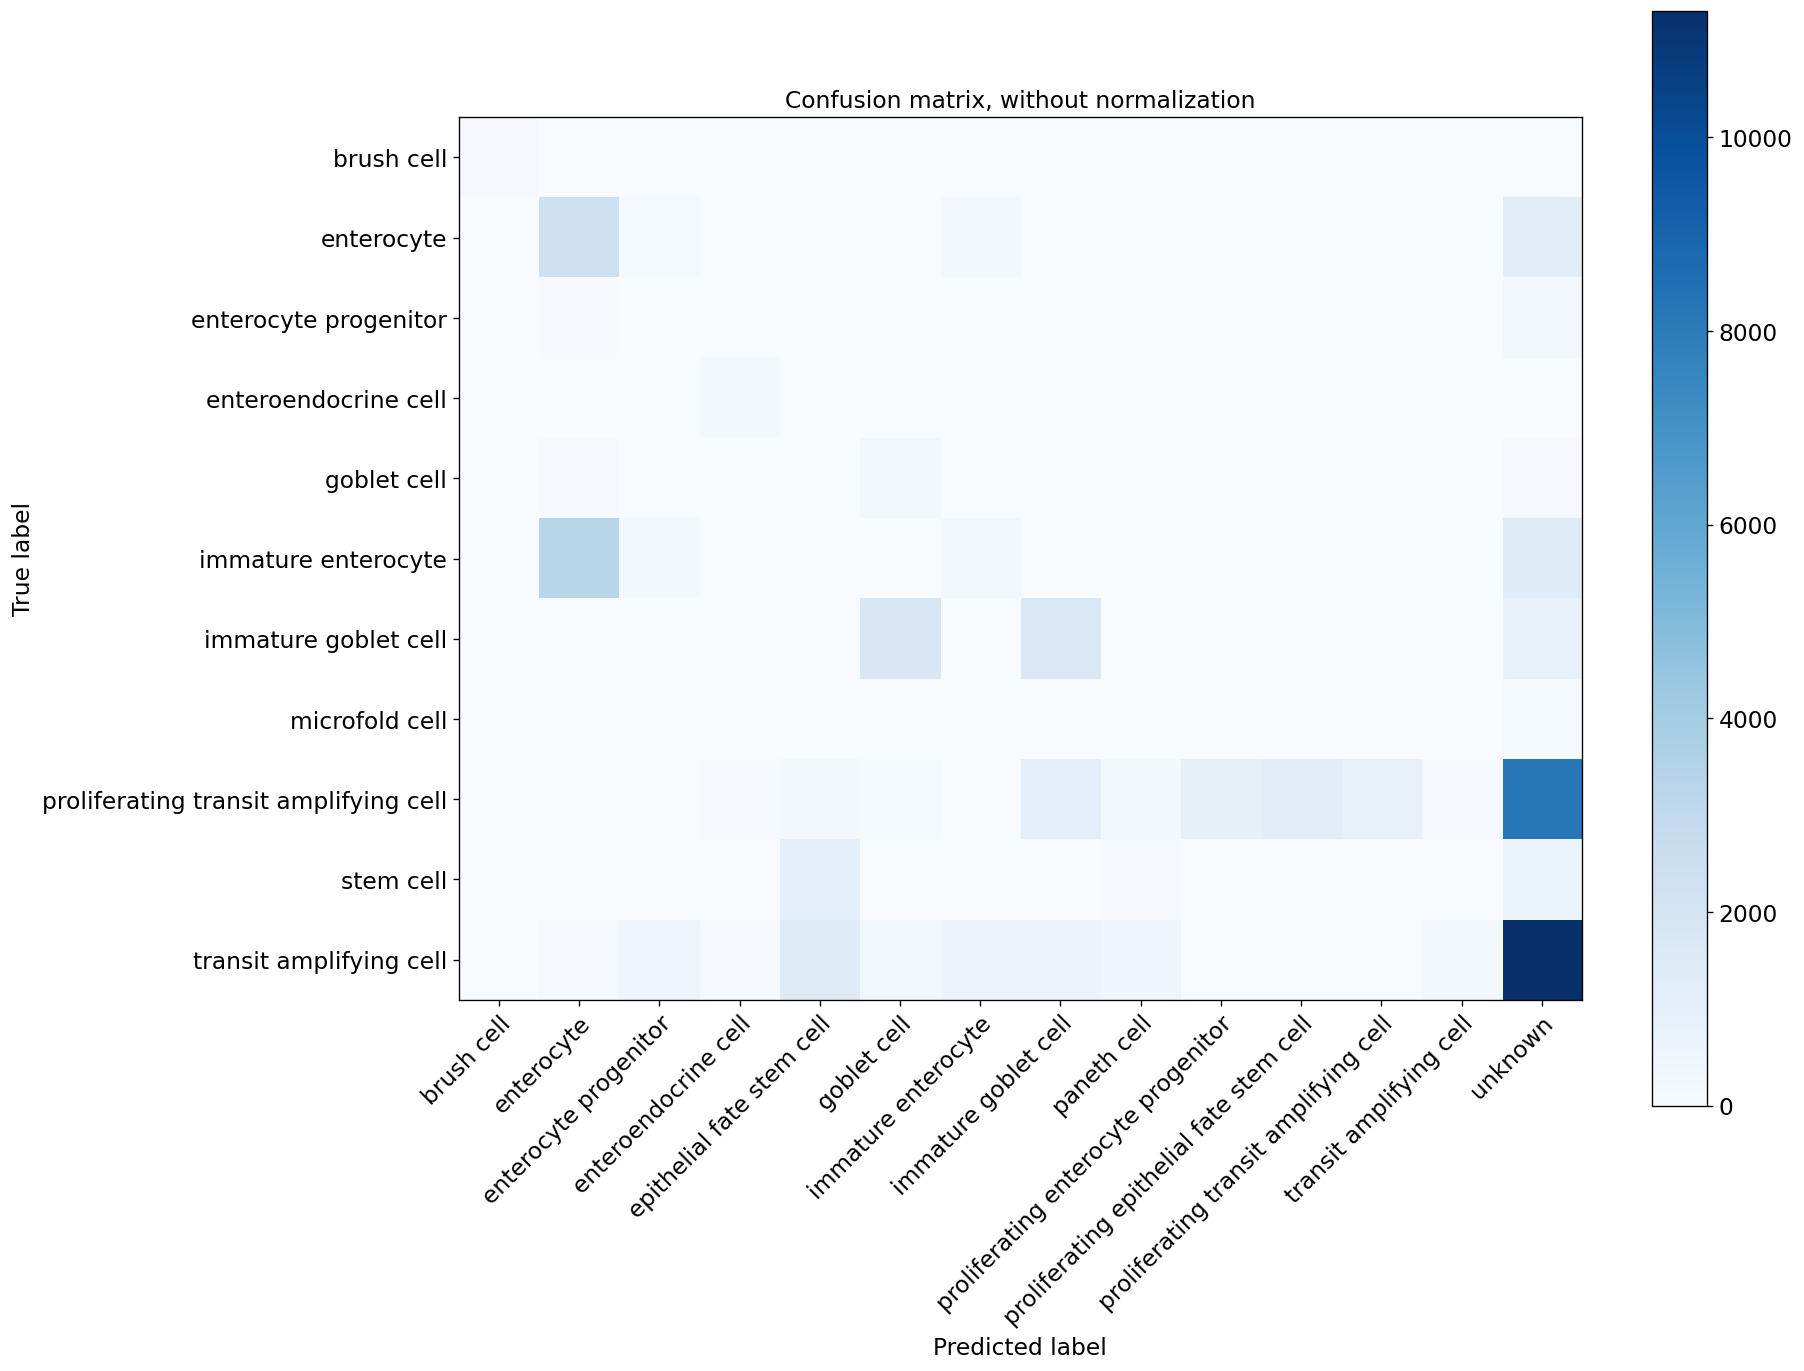

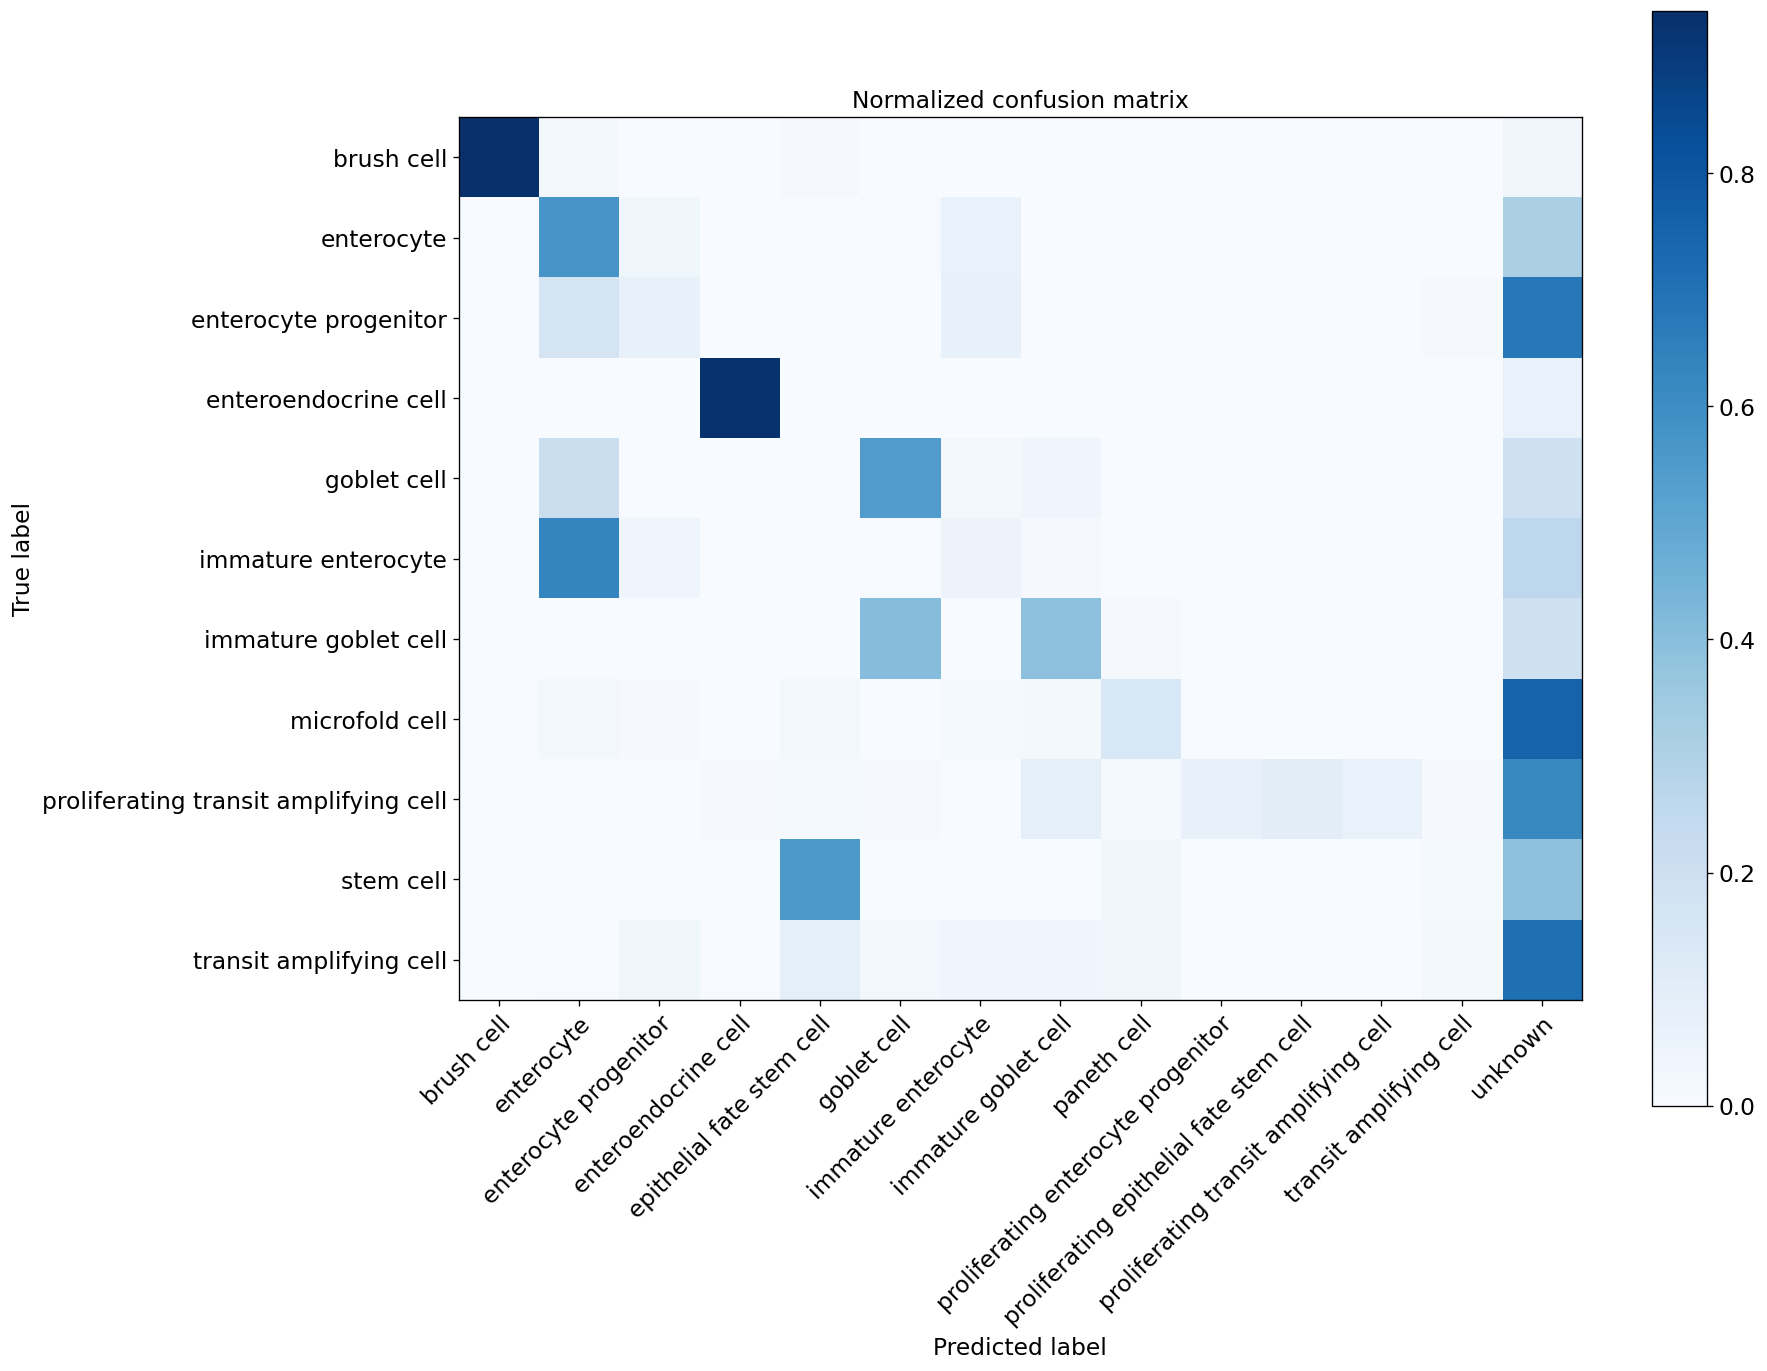

In [19]:
%matplotlib inline

bc.tl.report(adata_pred=adata_predicted, celltype=celltype_test, method=method, analysis_name=analysis_name,
                        train_datasets=adata_trains, test_dataset=adata_orig, merge=merge, use_raw=False,
                        genes_to_use=genes_to_use, remove_nonshared=True, clustering='leiden', asymmetric_matrix=True)

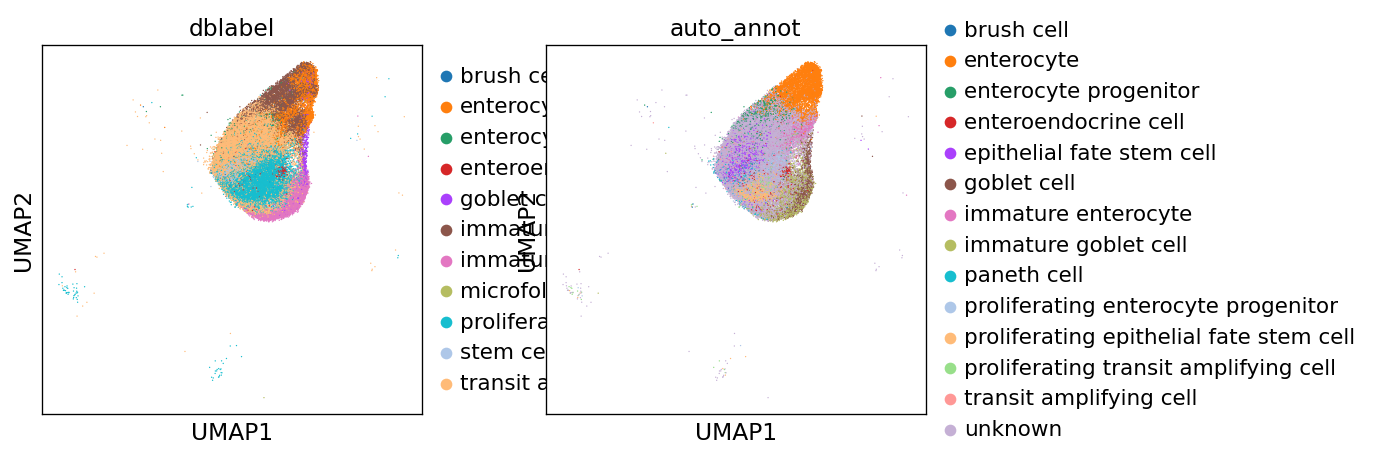

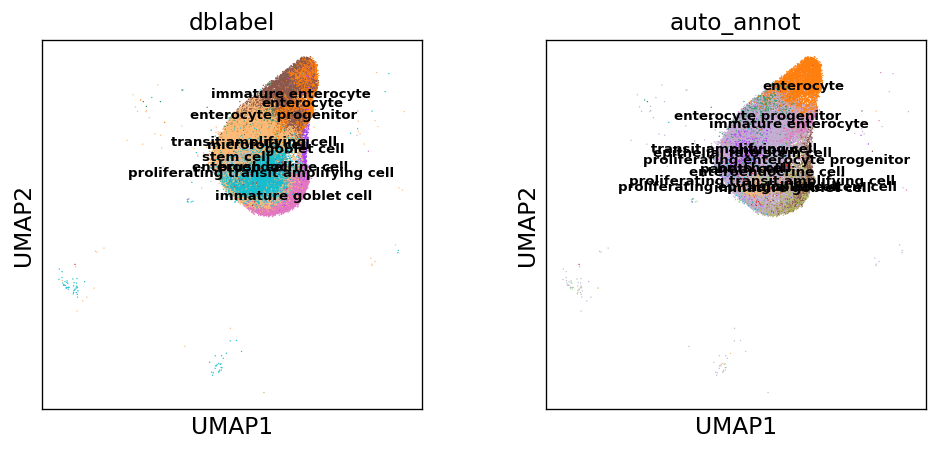

In [20]:
import scanpy as sc
sc.pl.umap(adata_predicted, color=[celltype_test, 'auto_annot'])
sc.pl.umap(adata_predicted, color=[celltype_test, 'auto_annot'], legend_loc='on data', legend_fontsize=8)

In [21]:
adata_train

View of AnnData object with n_obs × n_vars = 10896 × 270
    obs: 'CELL', 'CONDITION', 'sample_type', 'donor', 'region_x', 'sample', 'percent_mito', 'n_counts', 'n_genes', 'batch', 'leiden', 'celltype0', 'celltype1', 'celltype2', 'celltype3', 'dblabel', 'barcode', 'region_y', 'cell_label', '_merge'
    var: 'SYMBOL', 'ENSEMBL-0', 'n_cells-0', 'total_counts-0', 'frac_reads-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'mean-0', 'std-0', 'ENSEMBL-1', 'n_cells-1', 'total_counts-1', 'frac_reads-1', 'HGNC-1'

In [22]:
adata_predicted_wo_unknown = adata_predicted.copy()
adata_predicted_wo_unknown = bc.subset_adata(adata_predicted_wo_unknown, adata_predicted_wo_unknown.obs.auto_annot != 'unknown', raw=False)
bc.pl.riverplot_2categories(adata_predicted_wo_unknown, [celltype_test, 'auto_annot'])

In [23]:
from sinfo import sinfo
sinfo()

-----
anndata             0.7.4
besca               2.3+10.g22442ac.dirty
pandas              1.0.5
pkg_resources       NA
plotly              4.5.4
scanpy              1.6.0
sinfo               0.3.1
sklearn             0.22
-----
IPython             7.16.1
jupyter_client      6.1.6
jupyter_core        4.6.3
notebook            6.0.3
-----
Python 3.7.6 | packaged by conda-forge | (default, Jun  1 2020, 18:46:49) [GCC 7.5.0]
Linux-3.10.0-693.11.6.el7.x86_64-x86_64-with-centos-7.4.1708-Core
24 logical CPU cores, x86_64
-----
Session information updated at 2020-12-21 15:10
